# k-Nearest Neighbor (kNN) 练习


k-NN分类器由两个阶段组成

- 在训练过程中，分类器接受训练数据，并记录下来。
- 在测试阶段，kNN通过与所有训练图像进行比较并记录下k个最相似训练样本的标签，通过判断标签来对每个测试图像进行分类。
- k值需要交叉验证来确认。

在这个练习中，你需要实现这些不同的阶段所需的程序，同时理解图像分类的基本流程，交叉验证法，编写效率更高的向量化的代码。

In [1]:
# 在notebook运行这些启动程序.（这部分的代码属于启动代码，不需要理会，只要可以正常运行就可以）

import random
import numpy as np
from DSVC.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
# 在notebook中嵌套现实一些图像。不用理会这部分的代码。
%matplotlib inline
plt.rcParams['figure.figsize'] = (15., 12.) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
%load_ext autoreload
%autoreload 2

In [2]:
# 导入原始的CIFAR-10数据
cifar10_dir = 'DSVC/datasets/cifar-10-batches-py' 
# 你需要将CIFAR-10的数据放在这个路径下。


# 为了避免一些内存的问题，只导入了30000张图片的数据，参数3表示batch的组数。
# 你也可以将3改为6，去导入数据集的全部数据（60000张图片的数据）
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir, 3)

# 输出训练数据跟测试数据的维度.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (20000L, 32L, 32L, 3L)
Training labels shape:  (20000L,)
Test data shape:  (10000L, 32L, 32L, 3L)
Test labels shape:  (10000L,)


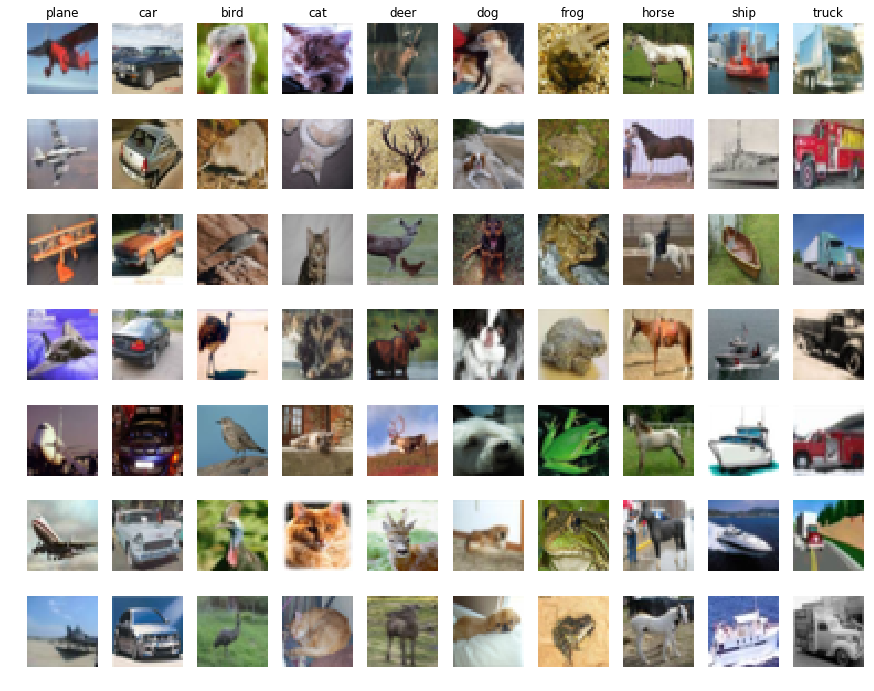

In [3]:
# 可视化一些样例数据
# 我们展示了每一类训练数据图像的几个例子。
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# 对数据进行采样，提高代码的执行效率。
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [5]:
# 将图像数据重新整理成行
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print X_train.shape, X_test.shape

(5000L, 3072L) (500L, 3072L)


In [6]:
from DSVC.classifiers import KNearestNeighbor

# 创建一个KNN分类器的实例
# 要注意，在训练KNN分类器的时候实际上是一个空操作
# 分类器只是简单的保存下了训练数据而没有做任何的处理 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

我们现在想用kNN分类器对测试数据进行分类。 回想一下，我们可以将这个过程分为两个步骤：

1. 首先，我们必须计算所有测试图像和所有训练图像之间的『距离』 
2. 计算出距离后，对于每个测试图像，我们需要找到『距离』最近的k个例子，并为它们投票来选择。

让我们开始计算所有的训练图像跟测试图像之间的『距离』矩阵。 

首先, 打开 `DSVC/classifiers/k_nearest_neighbor.py` 去实现里面所需的函数 `compute_distances_two_loops` 使用双重循环（效率不是很高，后面就发现为啥。）来遍历所有的训练样本跟测试样本数据对，去计算他们之间的『距离』

In [7]:
# 打开 DSVC/classifiers/k_nearest_neighbor.py 实现
# compute_distances_two_loops 这个函数.（其实是补全）

# 测试上面实现的compute_distances_two_loops函数 (k-NN的two_loop版本)
dists = classifier.compute_distances_two_loops(X_test)
print dists.shape

(500L, 5000L)


In [8]:
#现在需要先实现 predict_labels 函数（其实也是补全），运行下面的代码
# （还是在上面路径的 k_nearest_neighbor.py里）
#  K=1，其实就是一个最近邻算法。
y_test_pred = classifier.predict_labels(dists, k=1)

# 输出预测结果（正确的比例）
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 137 / 500 correct => accuracy: 0.274000


你的输出应该有 `27%`的准确率 . 让我们把 `k`改的更大试试, `k = 5`:

In [9]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 145 / 500 correct => accuracy: 0.290000


`k=5`的准确率应该略微的比`k=1`的时候要高一点。

In [10]:
# 现在可以通过使用部分矢量化来加快距离矩阵计算，只使用一重循环。 (也就是K-NN的one-loop版本)
# 实现函数compute_distances_one_loop并运行下面的代码.
# （还是在DSVC/classifiers/k_nearest_neighbor.py里实现这个函数）
dists_one = classifier.compute_distances_one_loop(X_test)

# （这里太长了，我没翻译） 
# 大概意思就是验证下你的one_loop的版本是否正确，会通过一个Frobenius范数来计算误差（这里的代码都是写好的，来验证你的函数实现的是否正确）
# 一次one_loop 版本跟 two_loop 版本的结果（这里假设你的two_loop的结果是正确的）
difference = np.linalg.norm(dists - dists_one, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same' # one_loop跟two_loop两个版本的程序没有误差的话，会输出这里
else:
  print 'Uh-oh! The distance matrices are different' # 输出这里表示你的one_loop的版本是错误的。

Difference was: 0.000000
Good! The distance matrices are the same


In [11]:
# 现在通过使用全部矢量化的操作来加快距离矩阵计算，不使用任何的循环。
# 实现完程序后来运行下面的代码。
# （我给点提示:完全平方公式）
dists_two = classifier.compute_distances_no_loops(X_test)

# 跟上面一样，检测你的no_loop的版本是不是正确的，同样还是假设two_loop的版本是正确的。
difference = np.linalg.norm(dists - dists_two, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same' # no_loop跟two_loop两个版本的程序没有误差的话，会输出这里
else:
  print 'Uh-oh! The distance matrices are different'# 输出这里表示你的no_loop的版本是错误的。

Difference was: 0.000000
Good! The distance matrices are the same


In [12]:
# 比较一下三种函数的实现的时间效率
def time_function(f, *args):
  """
  Call a function f with args and return the time (in seconds) that it took to execute.
  """
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print 'Two loop version took %f seconds' % two_loop_time

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print 'One loop version took %f seconds' % one_loop_time

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print 'No loop version took %f seconds' % no_loop_time

# 你应该会发现no_loop的版本是最快的。

Two loop version took 38.768000 seconds
One loop version took 92.056000 seconds
No loop version took 0.609000 seconds


### Cross-validation (交叉验证)

（这部分的英文部分就不翻译了，尝试翻译后的发现不如英文直接看来更准确。如果是看过交叉验证的相关资料的话，这里就没有难度了。）

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

There are three kinds of validation methods([introduction to these methods](http://www.cnblogs.com/zhaohongtian/p/6802327.html)). The method below is S-Folder Cross Validation. If it's difficult for you, use the simple cross-validation alternatively. 

In [14]:
# pass 部分是需要你去补上相应的代码的，代码的要求都在pass上面的ToDo:里写清楚了。
# pass 是python里的占位语句，也就是空语句，写你的代码的时候 要先把pass给删掉。
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
X_train_folds=np.array_split(X_train,num_folds)
y_train_folds=np.array_split(y_train,num_folds)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
for k in k_choices:
    k_to_accuracies[k] = np.zeros(num_folds)
    for i in range(num_folds):
        Xtrain=np.array(X_train_folds[:i]+X_train_folds[i+1:])
        ytrain=np.array(y_train_folds[:i]+y_train_folds[i+1:])
        Xtest=np.array(X_train_folds[i])
        ytest=np.array(y_train_folds[i])     
        Xtrain=np.reshape(Xtrain, (X_train.shape[0]*4/5,-1))
        ytrain=np.reshape(ytrain, (y_train.shape[0]*4/5,-1))
        Xtest=np.reshape(Xtest, (X_train.shape[0]/5,-1))
        ytest=np.reshape(ytest, (y_train.shape[0]/5,-1))
        classifier.train(Xtrain, ytrain)
        yte_pred=classifier.predict(Xtest, k)
        yte_pred=np.reshape(yte_pred, (yte_pred.shape[0], -1))
        correct=np.sum(yte_pred==ytest)
        accuracy=float(correct)/len(ytest)
        k_to_accuracies[k][i]=accuracy
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# 输出每次的准确度
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print 'k = %d, accuracy = %f' % (k, accuracy)

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.257000
k = 3, accuracy = 0.263000
k = 3, accuracy = 0.273000
k = 3, accuracy = 0.282000
k = 3, accuracy = 0.270000
k = 5, accuracy = 0.265000
k = 5, accuracy = 0.275000
k = 5, accuracy = 0.295000
k = 5, accuracy = 0.298000
k = 5, accuracy = 0.284000
k = 8, accuracy = 0.272000
k = 8, accuracy = 0.295000
k = 8, accuracy = 0.284000
k = 8, accuracy = 0.298000
k = 8, accuracy = 0.290000
k = 10, accuracy = 0.272000
k = 10, accuracy = 0.303000
k = 10, accuracy = 0.289000
k = 10, accuracy = 0.292000
k = 10, accuracy = 0.285000
k = 12, accuracy = 0.271000
k = 12, accuracy = 0.305000
k = 12, accuracy = 0.285000
k = 12, accuracy = 0.289000
k = 12, accuracy = 0.281000
k = 15, accuracy = 0.260000
k = 15, accuracy = 0.302000
k = 15, accuracy = 0.292000
k = 15, accuracy = 0.292000
k = 15, accuracy = 0.285000
k = 20, accuracy = 0.268000
k = 20, accu

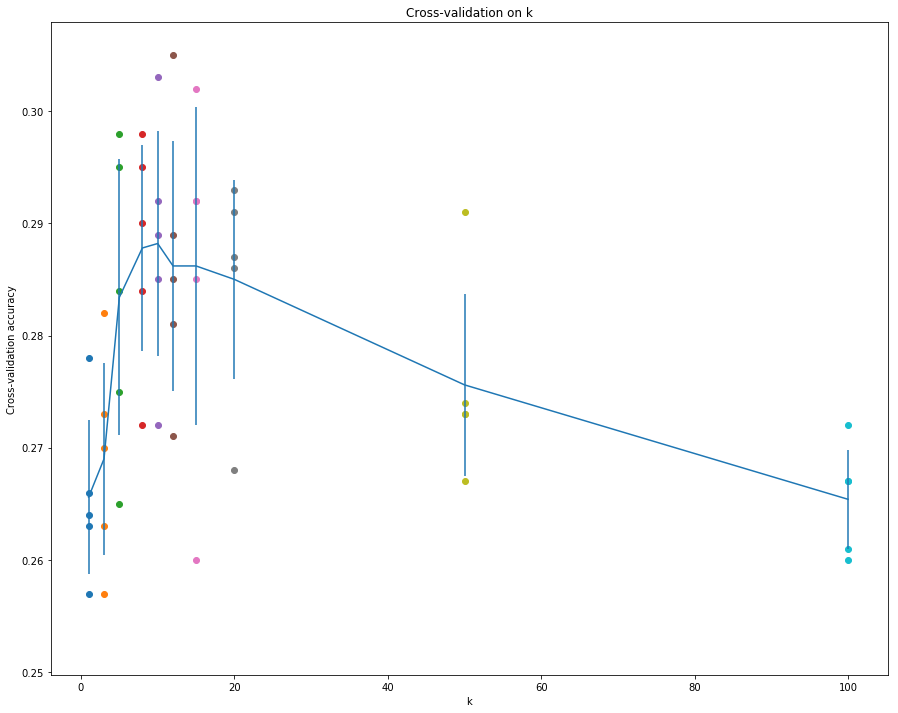

In [15]:
# 如果上述都是正确的话，这里会给出不同的k下交叉验证的准确率的折线图，通过这个图来判断在当前数据集下的最合适的K是多少。
# plot the raw observations
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [16]:
# 基于上面的交叉验证的结果，来选择一个准确率最高的K，（也就是跟上面的代码输出的图像来判断）
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 8

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 147 / 500 correct => accuracy: 0.294000
